# Text Classification with Unsupervised and Supervised Techniques

In this report, I will exlore a corpus of presidential state-of-the-union speeches to see if I can predict the president given an excerpted paragraph. I will transform the paragraphs into vectorized components using tf-idf and bag-of-words feature generation. I will then evaluate these transformed datasets using supervised and unsupervised methods. 25% of the data will be reserved as a hold-out group for external validation. <br>

Let's get started!

In [74]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy
import nltk
from nltk.corpus import state_union

from collections import defaultdict

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn import metrics

from collections import Counter

from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from sklearn.svm import LinearSVC

nlp = spacy.load('en')

# Cleaning Data

Let's take a look at the filenames in this corpora.

In [4]:
print(state_union.fileids())

['1945-Truman.txt', '1946-Truman.txt', '1947-Truman.txt', '1948-Truman.txt', '1949-Truman.txt', '1950-Truman.txt', '1951-Truman.txt', '1953-Eisenhower.txt', '1954-Eisenhower.txt', '1955-Eisenhower.txt', '1956-Eisenhower.txt', '1957-Eisenhower.txt', '1958-Eisenhower.txt', '1959-Eisenhower.txt', '1960-Eisenhower.txt', '1961-Kennedy.txt', '1962-Kennedy.txt', '1963-Johnson.txt', '1963-Kennedy.txt', '1964-Johnson.txt', '1965-Johnson-1.txt', '1965-Johnson-2.txt', '1966-Johnson.txt', '1967-Johnson.txt', '1968-Johnson.txt', '1969-Johnson.txt', '1970-Nixon.txt', '1971-Nixon.txt', '1972-Nixon.txt', '1973-Nixon.txt', '1974-Nixon.txt', '1975-Ford.txt', '1976-Ford.txt', '1977-Ford.txt', '1978-Carter.txt', '1979-Carter.txt', '1980-Carter.txt', '1981-Reagan.txt', '1982-Reagan.txt', '1983-Reagan.txt', '1984-Reagan.txt', '1985-Reagan.txt', '1986-Reagan.txt', '1987-Reagan.txt', '1988-Reagan.txt', '1989-Bush.txt', '1990-Bush.txt', '1991-Bush-1.txt', '1991-Bush-2.txt', '1992-Bush.txt', '1993-Clinton.txt',

From previous runs of this code, we can see that presidents Bush, Ford, and Carter have an insufficient amount of data. While Truman, Eisenhower, and Johnson have upwards of 1000 paragraphs of text, Bush, Ford, and Carter all have less than 350. To prevent heavy class imbalance, I will cut these presidents from the corpora using a list comprehension. This will ensure that future models are not built upon a dataset where presidents are represented unequally, as this could skew results towards the larger classes. After cutting these presidents out, I will then create a master list of paragraphs per each remaining president. <br>

Here are a few features I didn't include, but that are options: num_chars, num_words, num_sents, num_paras, num_chars/num_words, num_words/num_sents, num_words/num_vocab, file. These would add features to the dataset that might be indicative of writing style. Since we will be looking at whether or not we can use features to predict/cluster by president, features that convey writing style might be helpful. However, to simplify this initial analysis, let's start with using the contents of the paragraphs to create vectorized components, with the option of adding these sentence/paragraph summary features later.

In [5]:
para_counts_per_president = defaultdict(int)
sentence_counts_per_president = defaultdict(int)
word_counts_per_president = defaultdict(int)

paras_list = []
lemma_paras_list = []

removals = ['-Bush','-Ford','-Carter']

fileids = [
    file for file in state_union.fileids()
    if not any(substring in file for substring in removals)
    ]

for file in fileids:
    num_words = len(state_union.words(file))
    num_sents = len(state_union.sents(file))
    num_paras = len(state_union.raw(file).split('\n'))
    
    # We split and define paragraphs by a new line, but some paragraphs have two lines between them --> replace
    file = file.replace('\n\n','\n')
    
    # Reformat file titles so presidents can be grouped together
    president_name = file[5:].replace('.txt','').split('-')[0]
    
    para_counts_per_president[president_name] += num_paras
    sentence_counts_per_president[president_name] += num_sents
    word_counts_per_president[president_name] += num_words
    
    paras = state_union.raw(file).split('\n')
    tup = tuple([(para, president_name) for para in paras])
    paras_list.append(tup)
    
print('Paragraphs per President\n', para_counts_per_president)
print('\nSentences per President\n', sentence_counts_per_president)
print('\nWords per President\n', word_counts_per_president)

# Flatten our list of tuples to make it easier to convert into dataframe later
flat_list = [item for tuple in paras_list for item in tuple]

Paragraphs per President
 defaultdict(<class 'int'>, {'Truman': 1214, 'Eisenhower': 1032, 'Kennedy': 405, 'Johnson': 1217, 'Nixon': 537, 'Reagan': 589, 'Clinton': 833, 'GWBush': 629})

Sentences per President
 defaultdict(<class 'int'>, {'Truman': 2582, 'Eisenhower': 2333, 'Kennedy': 730, 'Johnson': 1779, 'Nixon': 832, 'Reagan': 1866, 'Clinton': 3122, 'GWBush': 2160})

Words per President
 defaultdict(<class 'int'>, {'Truman': 59237, 'Eisenhower': 54081, 'Kennedy': 20455, 'Johnson': 39534, 'Nixon': 21767, 'Reagan': 42825, 'Clinton': 70284, 'GWBush': 38695})


Now to convert that list into a dataframe for easier analysis. We will be using the president as the outcome feature.

In [6]:
paras_df = pd.DataFrame(flat_list, columns = ['para','president'])
paras_df.head(10)

,para,president
0,PRESIDENT HARRY S. TRUMAN'S ADDRESS BEFORE A J...,Truman
1,,Truman
2,"April 16, 1945",Truman
3,,Truman
4,"Mr. Speaker, Mr. President, Members of the Con...",Truman
5,It is with a heavy heart that I stand before y...,Truman
6,"Only yesterday, we laid to rest the mortal rem...",Truman
7,"Yet, in this decisive hour, when world events ...",Truman
8,"In His infinite wisdom, Almighty God has seen ...",Truman
9,No man could possibly fill the tremendous void...,Truman


Add columns for spacy-tokenized paragraphs, and their corresponding list of lemmas. We will use the lemmatized versions of words to remove excess noisy features that mean the same thing. This means that conjugations and alternate versions of words would be grouped together as a concept instead of treated individually. This avoids creating too many noisy features that are only used a few times, which would complicate the feature space unnecessarily. Additionally, some of these words might miss the count threshold if not converted to lemmas, which would exclude them from the feature space altogether. <br>

Since all pronouns (e.g. we, our) are converted to the generic lemma term "-PRON-", we will exclude this term from our features. Because so many different words can be simplified to this ubiquitous term, leaving it in might mislead our clusters into grouping by something that doesn't truly represent similarity. <br>

In [73]:
paras_df['spacy_para'] = paras_df['para'].apply(lambda x: nlp(x))

def lemmatize(x):
    return [token.lemma_ for token in x
                      if not token.is_stop
                      and not token.is_punct
                      and not token.lemma_ == "-PRON-"
                      and not token.lemma_ == " " or "  "
    ]

paras_df['lemma_para'] = paras_df['spacy_para'].apply(lambda x: lemmatize(x))
print(paras_df.head(200))

                                                  para president  \
0    PRESIDENT HARRY S. TRUMAN'S ADDRESS BEFORE A J...    Truman   
1                                                         Truman   
2                                       April 16, 1945    Truman   
3                                                         Truman   
4    Mr. Speaker, Mr. President, Members of the Con...    Truman   
5    It is with a heavy heart that I stand before y...    Truman   
6    Only yesterday, we laid to rest the mortal rem...    Truman   
7    Yet, in this decisive hour, when world events ...    Truman   
8    In His infinite wisdom, Almighty God has seen ...    Truman   
9    No man could possibly fill the tremendous void...    Truman   
10   Tragic fate has thrust upon us grave responsib...    Truman   
11   So much blood has already been shed for the id...    Truman   
12   Today, the entire world is looking to America ...    Truman   
13   With great humility I call upon all America

Now to define the X/Y terms that we will pass into our feature generators, and convert our list of tokens to a list of strings. X is the collection of paragraphs, and Y is the president that each paragraph comes from.

In [9]:
X = paras_df['lemma_para']
Y = paras_df['president']

X_strings = [
    ' '.join([str(word) for word in para])
    for para in X.values.tolist()
]

print(len(X_strings))

6456


Looks like we have 6456 paragraph datapoints for the 8 chosen presidents.

# Feature Generation

Let's first try creating features using the tf-idf vectorizer.

In [11]:
def tfidf_vectorizer(X,Y):
    vectorizer = TfidfVectorizer(max_df=0.5,
                                 min_df=2,
                                 stop_words='english', 
                                 lowercase=True,
                                 norm=u'l2',
                                 smooth_idf=True,
                                )

    sparse_tfidf_matrix=vectorizer.fit_transform(X_strings)
    print(f'Number of features: {sparse_tfidf_matrix.get_shape()[1]}')
    
    # Densify matrix so we can convert it to a conventional dataframe to extract X/Y
    dense_tfidf_matrix = sparse_tfidf_matrix.todense()
    df_tfidf = pd.DataFrame(dense_tfidf_matrix)
    df_tfidf['lemma_para'] = X
    df_tfidf['president'] = Y
    
    return df_tfidf

tfidf_df = tfidf_vectorizer(X_strings,Y)

Number of features: 5284


Now let's try creating features using the count vectorizer (bag-of-words).

In [13]:
def count_vectorizer(X,Y):
    vectorizer = CountVectorizer(max_df=0.5,
                                 min_df=2,
                                 stop_words='english', 
                                 lowercase=True
                                )

    sparse_count_matrix=vectorizer.fit_transform(X_strings)
    print(f'Number of features: {sparse_count_matrix.get_shape()[1]}')
    
    dense_count_matrix = sparse_count_matrix.todense()
    df_count = pd.DataFrame(dense_count_matrix)
    df_count['lemma_para'] = X
    df_count['president'] = Y
    
    return df_count

count_df = count_vectorizer(X_strings,Y)

Number of features: 5284


Since we used the same hyperparameters for both vectorizers, they both returned datasets with 5284 features. Each of these features represents a word that meets the criteria specified in the hyper-parameters.<br>

For the bag-of-words(count vectorizer), The value of each feature depends solely on its frequency in each paragraph. This creates high-dimensional, sparse data in which the order, structure, and meaning of the words are discarded. <br>

The tf-idf vectorizer is a modification of the bag-of-words model, where along with the frequency of the word we also consider how often the word appears in the entire corpus. Features are weighted strongly when they appear often in a small set of documents, and stop-words and other frequent words with little significance are weighted less. <br>

Because tf-idf is a more nuanced version of bag-of-words, it allows for more information to be captured within each feature. For this reason, I believe it will be a stronger predictor of our outcome class than the simple bag-of-words model. <br>

Now, let's create training and testing datasets to evaluate the clustering of these two datasets. t represents tf-idf and c represents count. I have reserved 25% of the data for external testing.

In [14]:
tX = tfidf_df.drop(['lemma_para','president'], axis=1)
tY = tfidf_df['president']
tX_train, tX_test, tY_train, tY_test, t_train, t_test = train_test_split(tX,
                                                        tY,
                                                        tfidf_df,
                                                        test_size = 0.25,
                                                        random_state = 1)

cX = count_df.drop(['lemma_para','president'], axis=1)
cY = count_df['president']
cX_train, cX_test, cY_train, cY_test, c_train, c_test = train_test_split(cX,
                                                        cY,
                                                        count_df,
                                                        test_size = 0.25,
                                                        random_state = 1)

Create subsets of each dataset so we can objectively compare our clustering algorithms. Since we don't have a ground truth to compare our clustering to, we can split our data into subsets to compare how each subset compares to eachother. The more our subsets resemble eachother, the more stable our clustering is, and the more we can count on the algorithm to cluster similarly in the future with unseen data.

In [15]:
tA, tB = train_test_split(tX_train, test_size = 0.5, random_state = 1)
tfidf_subsets = (
    train_test_split(tA, test_size = 0.5, random_state = 1) +
    train_test_split(tB, test_size = 0.5, random_state = 1))

cA, cB = train_test_split(cX_train, test_size = 0.5, random_state = 1)
bow_subsets = (
    train_test_split(cA, test_size = 0.5, random_state = 1) +
    train_test_split(cB, test_size = 0.5, random_state = 1))

# Clustering

Now let's put our new features to work. Since there are 8 presidents, we will first specify 8 clusters for k-means to see if they naturally cluster by president.

We will be assessing the cluster shape consistency visually, as well as silhouette scores per each subset and the full dataset. A high silhouette score (close to 1) would indicate that clusters are dense and easily separable from each other (with relatively short distances between points), while a low silhouette score would indicate that clusters are sparse and overlapping.

# K-Means

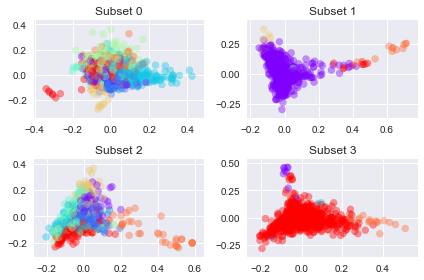

Silhouette Scores: [0.0035870772230050456, 0.03372196137304373, 0.0050726420483428415, 0.018132627643981727]
Silhouette Scores Mean: 0.0151285770721
Silhouette Standard Deviation: 0.0121353441192
Full Dataset


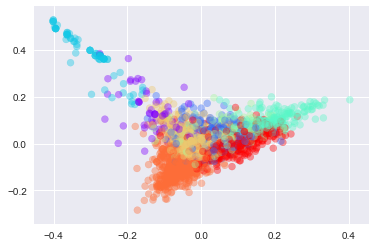

Silhouette Score: 0.0153122974013


In [16]:
def pca_2_component(X):
    pca = PCA(n_components=2)
    X_norm = normalize(X)
    X_pca = pca.fit_transform(X_norm)
    return X_pca

def k_means(full_set, subsets,n):
    f, plotgrid = plt.subplots(2,2)
    sil_scores = []   
    
    for i in range(4):
        model = KMeans(n_clusters=n, random_state = 1)
        model.fit(subsets[i])
        labels = model.predict(subsets[i])
        
        # Reduce features to 2 components for visualization/plotting
        coordinates = pca_2_component(subsets[i])
        xs = coordinates[:,0]
        ys = coordinates[:,1]
        
        rows = int(np.floor(i / 2))
        cols = i % 2
        colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

        plotgrid[rows, cols].scatter(xs, ys, color = colors[labels], alpha = 0.4)
        plotgrid[rows, cols].set_title(f'Subset {i}')
        
        sil_scores.append(metrics.silhouette_score(subsets[i], labels, metric='euclidean'))
    
    plt.tight_layout()
    plt.show()
    print('Silhouette Scores:', sil_scores)
    print('Silhouette Scores Mean:', np.mean(sil_scores))
    print('Silhouette Standard Deviation:', np.std(sil_scores))
        
    print('Full Dataset')
        
    model = KMeans(n_clusters=n, random_state = 1)
    model.fit(full_set)
    labels = model.predict(full_set)

    coordinates = pca_2_component(full_set)
    xs = coordinates[:,0]
    ys = coordinates[:,1]

    colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
    plt.scatter(xs, ys, c=colors[labels], alpha=0.4)
    plt.show()
    
    print('Silhouette Score:', metrics.silhouette_score(full_set, labels, metric='euclidean'))
    
    return labels
    
k_means_tfidf_labels = k_means(tX_train, tfidf_subsets, 8)

This silhouette score is pretty low (**0.015**) using the tf-idf dataset. Let's see if using the bag-of-words dataset gives us any better clusters.

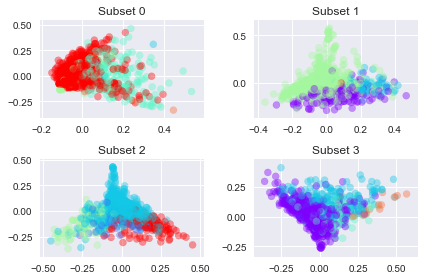

Silhouette Scores: [0.02115733885984368, 0.25206812706845327, 0.15919811248687474, 0.18417008671951049]
Silhouette Scores Mean: 0.154148416284
Silhouette Standard Deviation: 0.0839668038007
Full Dataset


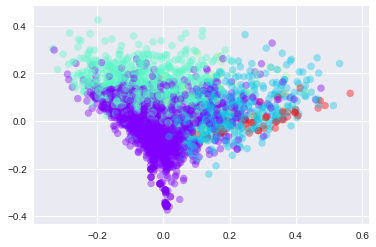

Silhouette Score: 0.174513101022


In [17]:
k_means_bow_labels = k_means(cX_train, bow_subsets, 8)

The silhouette score is **0.175** using bag-of-words, which is over 10x higher than the silhouette score of the tfidf dataset.

Let's look into these clusters and see if they match up to the various presidents. For each president in the corpus, we will check the cluster distribution. Ideally, we would like to see that each president is dominant for one particular cluster. For example, we would like to see Clinton with overwhelming representation for Cluster 0 (and few to no datapoints in other clusters), Eisenhower dominant for Cluster 1, etc.

Clinton
7    266
5    148
6    118
4     29
1     15
3     13
2     12
0     12
Name: k_means_pred, dtype: int64


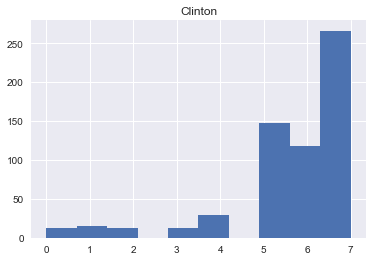

Eisenhower
5    303
1    186
6    125
4     89
3     34
7     17
0      8
2      7
Name: k_means_pred, dtype: int64


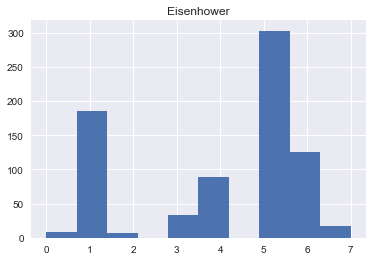

GWBush
5    219
6    134
7     88
1     11
4     10
2     10
0      9
3      4
Name: k_means_pred, dtype: int64


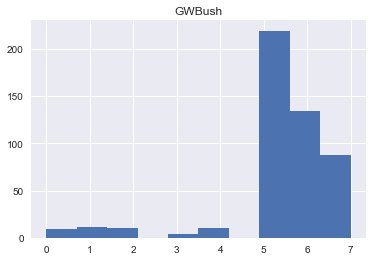

Johnson
5    503
6    137
4     73
1     73
7     68
3     25
0     19
2     15
Name: k_means_pred, dtype: int64


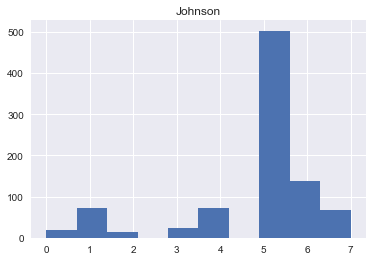

Kennedy
5    160
6     50
1     33
4     23
7     20
3     10
0      7
2      3
Name: k_means_pred, dtype: int64


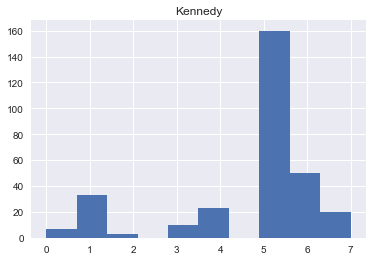

Nixon
5    172
6     84
1     47
4     31
7     29
0     15
3     10
2      8
Name: k_means_pred, dtype: int64


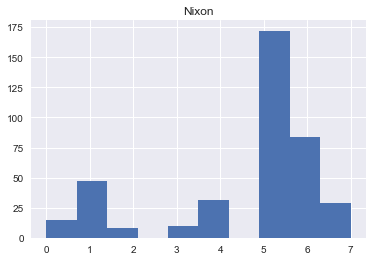

Reagan
5    123
6    121
7     75
4     33
1     32
3     31
2     11
0     11
Name: k_means_pred, dtype: int64


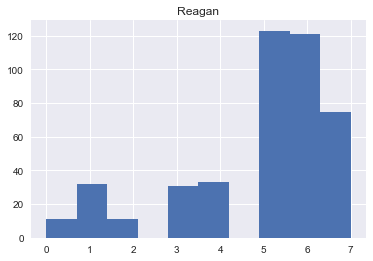

Truman
5    321
1    249
6    152
3     91
4     63
7     25
0     13
2      9
Name: k_means_pred, dtype: int64


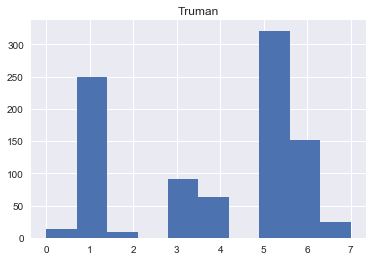

In [18]:
tfidf_cluster_pred = pd.DataFrame()
tfidf_cluster_pred['president'] = tY_train
tfidf_cluster_pred['k_means_pred'] = k_means_tfidf_labels

for group, rows in tfidf_cluster_pred.groupby('president'):
    print(group)
    print(rows['k_means_pred'].value_counts())
    plt.hist(rows['k_means_pred'])
    plt.title(group)
    plt.show()

With all of our clustering algorithms, we hope to see each president populating a unique cluster. With K Means clustering on the tf-idf dataset, we don't see a strong distinction between presidents. For example, in speech excerpts from Eisenhower, we see 303 observations in Cluster 5, with 186 in Cluster 1 and 125 in Cluster 6. This shows that the algorithm is clustering on criteria that doesn't necessarily match the president of the paragraph. <br>

Additionally, many of the presidents are dominant for the same cluster. All presidents except Clinton have the most observations in Cluster 5. It is possible that without tuning the hyperparameters of the vectorizer, we are unable to distinguish between speech styles, or it may be that clustering is not the appropriate way to distinguish. Let's make a plot to visualize how the clusters compare to eachother in size.<br>

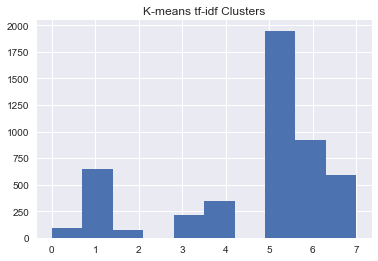

In [116]:
plt.hist(k_means_tfidf_labels)
plt.title('K-means tf-idf Clusters')
plt.show()

Now we can clearly see that Cluster 5 has the most number of datapoints by far, with Cluster 0 and 2 harboring very few. Let's take a look at the clusters of the bag-of-words dataframe.

Clinton
3    260
0    233
2     96
4     24
Name: k_means_pred, dtype: int64


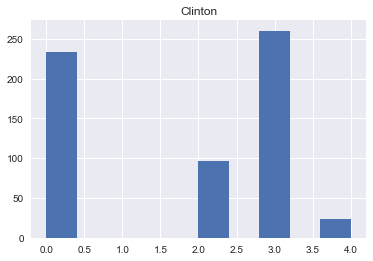

Eisenhower
0    557
3    105
2     94
4      8
7      4
1      1
Name: k_means_pred, dtype: int64


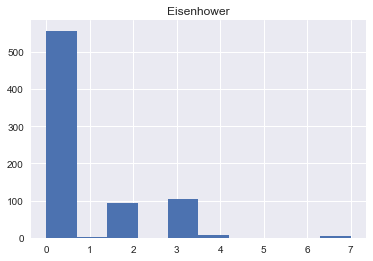

GWBush
0    281
3    166
2     25
4     11
7      1
6      1
Name: k_means_pred, dtype: int64


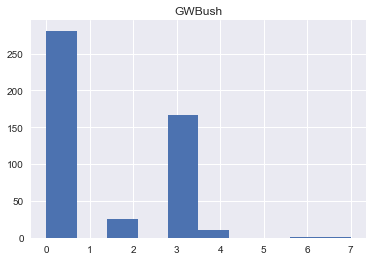

Johnson
0    820
3     46
2     43
4      3
5      1
Name: k_means_pred, dtype: int64


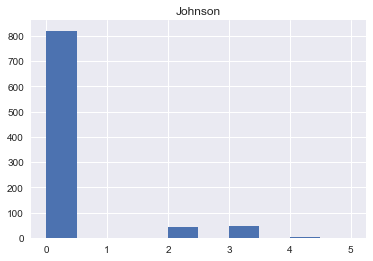

Kennedy
0    234
3     41
2     25
4      5
7      1
Name: k_means_pred, dtype: int64


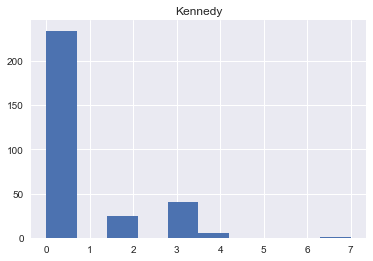

Nixon
0    315
3     43
2     38
Name: k_means_pred, dtype: int64


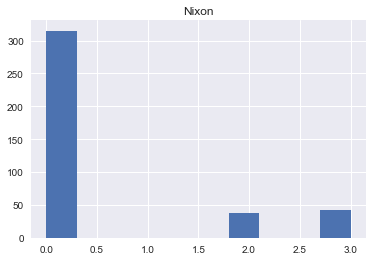

Reagan
0    211
3    133
2     72
4     20
7      1
Name: k_means_pred, dtype: int64


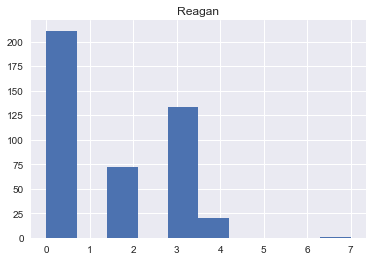

Truman
0    672
2    112
3     96
7     38
4      5
Name: k_means_pred, dtype: int64


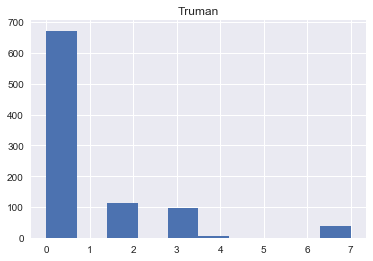

In [21]:
bow_cluster_pred = pd.DataFrame()
bow_cluster_pred['president'] = cY_train
bow_cluster_pred['k_means_pred'] = k_means_bow_labels

for group, rows in bow_cluster_pred.groupby('president'):
    print(group)
    print(rows['k_means_pred'].value_counts())
    plt.hist(rows['k_means_pred'])
    plt.title(group)
    plt.show()

With the bag-of-words dataframe, most presidents are Cluster 0 dominant. Although k-means clusters are of the same area in the feature space, because they vary in density they will not always assign the same number of elements to every cluster. This is why it is possible for Cluster 0 to have so many observations while Cluster 7, for example has so few. Let's confirm this with a cluster size histogram.<br>

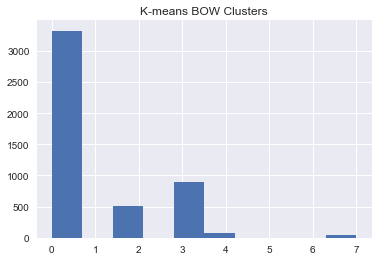

0    3323
3     890
2     505
4      76
7      45
6       1
5       1
1       1
dtype: int64


In [117]:
plt.hist(k_means_bow_labels)
plt.title('K-means BOW Clusters')
plt.show()
print(pd.Series.value_counts(k_means_bow_labels))

Over 3000 paragraphs in Cluster 0, and only 1 datapoint each in Clusters 1, 5, and 6! <br>

It is clear that this clustering algorithm is not effectively separating by president, so what it is it separating on? Because we are working with natural language, we don't have many user-friendly features to generate summary statistics on -- we will have to come up with more creative ways to look into each cluster. <br>

Let's look at the top 20 most frequent words in each cluster to get a picture of what's inside these groups.

In [114]:
from itertools import chain

t_train_pred = t_train.loc[:,['lemma_para', 'president']]
t_train_pred['cluster_pred'] = k_means_tfidf_labels

def get_common_words(clusters, df, pred):

    cluster_words = {}
    
    for value in np.unique(clusters):
        cluster_paras = df.loc[df[pred] == value].lemma_para.tolist()
        cluster_paras_lists = [word.split() for word in cluster_paras]
        individual_words_list = list(chain.from_iterable(cluster_paras_lists))
        common_words = [Counter(individual_words_list).most_common(20)]
        cluster_words[value] = common_words

    return cluster_words

k_means_tfidf_words = get_common_words(k_means_tfidf_labels, t_train_pred, 'cluster_pred')
for key, value in k_means_tfidf_words.items():
    print(key, value, '\n')

0 [[('state', 81), ('union', 72), ('january', 28), ('year', 24), ('congress', 23), ('message', 16), ('the', 16), ('president', 14), ('report', 13), ('time', 13), ('today', 11), ('world', 11), ('nation', 9), ('american', 9), ('strong', 9), ('people', 8), ('come', 8), ('history', 8), ('address', 7), ('republic', 7)]] 

1 [[('government', 286), ('the', 215), ('federal', 154), ('congress', 148), ('increase', 148), ('price', 141), ('need', 134), ('policy', 112), ('economic', 110), ('labor', 109), ('year', 103), ('economy', 98), ('new', 96), ('resource', 94), ('trade', 94), ('business', 92), ('production', 88), ('in', 85), ('people', 83), ('wage', 83)]] 

2 [[('the', 88), ('president', 83), ('mr.', 74), ('congress', 66), ('of', 47), ('speaker', 43), ('member', 30), ('state', 29), ('union', 28), ("'s", 27), ('fellow', 26), ('on', 26), ('joint', 19), ('session', 19), ('to', 19), ('distinguish', 18), ('guest', 18), ('American', 18), ('address', 18), ('message', 16)]] 

3 [[('year', 287), ('doll

It seems that the algorithm is clustering on topic. Cluster 3 is about money and finances. Cluster 2 is self-referential to the state-of-the-union address, perhaps coming from headings. Cluster 6 consists of positive American buzz-words like freedom and peace. These are general topics that are covered by every president so it makes sense as to why the presidents don't map clearly to individual clusters. <br>

Let's see if the clusters are similar for the bag-of-words dataset.

In [118]:
c_train_pred = c_train.loc[:,['lemma_para', 'president']]
c_train_pred['cluster_pred'] = k_means_bow_labels

k_means_bow_words = get_common_words(k_means_bow_labels, c_train_pred, 'cluster_pred')
for key, value in k_means_bow_words.items():
    print(key, value, '\n')

0 [[('the', 560), ('congress', 359), ('nation', 333), ('have', 313), ('government', 258), ('new', 249), ('great', 242), ('and', 236), ('year', 231), ('program', 221), ('but', 220), ('people', 211), ('in', 208), ('war', 204), ('world', 203), ('need', 202), ('america', 193), ('this', 182), ('time', 182), ('president', 180)]] 

1 [[('personnel', 5), ('survivor', 4), ('retirement', 4), ('system', 4), ('career', 3), ('need', 3), ('federal', 3), ('military', 3), ('old', 3), ('age', 3), ('insurance', 3), ('protection', 3), ('employee', 2), ('government', 2), ('improve', 2), ('improvement', 2), ('benefit', 2), ('civilian', 2), ('committee', 2), ('the', 2)]] 

2 [[('year', 637), ('program', 263), ('federal', 227), ('government', 221), ('the', 197), ('budget', 169), ('increase', 165), ('congress', 144), ('have', 132), ('new', 129), ('billion', 126), ('$', 122), ('need', 117), ('this', 108), ('million', 108), ('work', 103), ('time', 99), ('national', 93), ('school', 93), ('in', 92)]] 

3 [[('peop

These clusters are slightly different. There is greater representation for money-focused clusters, and they seem to be more specific than the clusters from tf-idf. This must be because of the way the vectorizer places value on different words. In tf-idf, the term weight is represented in vector space, and it reflects both the frequency in the document as well as the whole corpus. Bag-of-words is slightly more simple, and only reflects the word frequencies in that document. <br>


Instead of defining our clusters at k = 8, let's try iterating through several values of k to see if we might be able to cluster more effectively. In the interest of time, we will iterate through the algorithm up to 8 clusters. Resulting cluster arrangements will be judged by their mean silhouette scores, which is a measure of cluster cohesion.

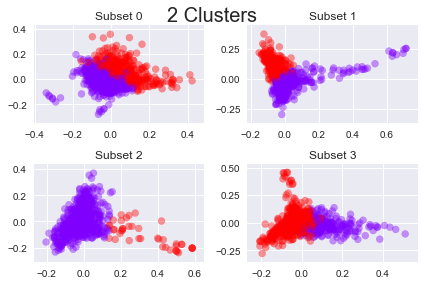

Silhouette Scores: [0.033094840737382454, 0.036183220605224553, 0.036459749149023675, 0.033674571483327538]


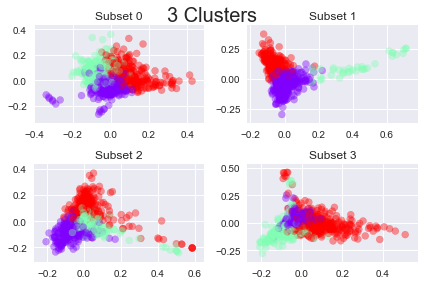

Silhouette Scores: [0.022415446229941936, 0.038039879234043519, 0.012022128006211663, 0.011885536129478552]


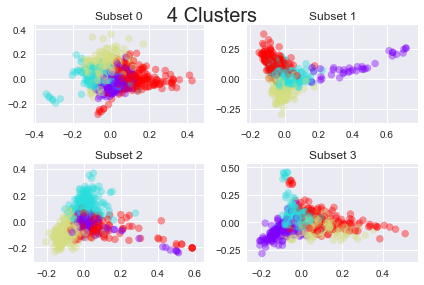

Silhouette Scores: [0.013953757048663548, 0.026362666759969955, 0.0017891276157054412, 0.010312624462049919]


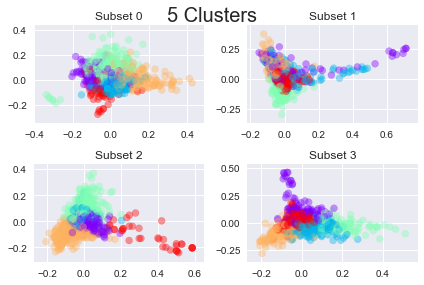

Silhouette Scores: [0.011749489019760615, 0.020015760104340693, 0.012627541687312536, 0.0093908122343674284]


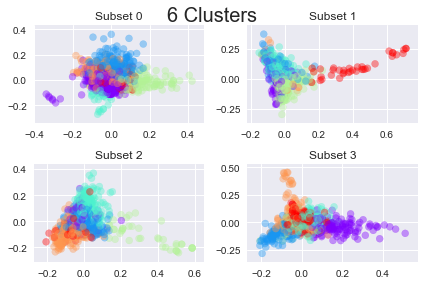

Silhouette Scores: [0.022011170891139818, 0.030511495236873916, 0.013582130962765445, 0.0013630121215897474]


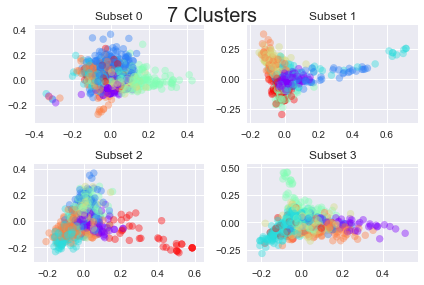

Silhouette Scores: [-0.015712920283475401, 0.0098476270178409191, -0.0054673718496301904, 0.023657338864646354]


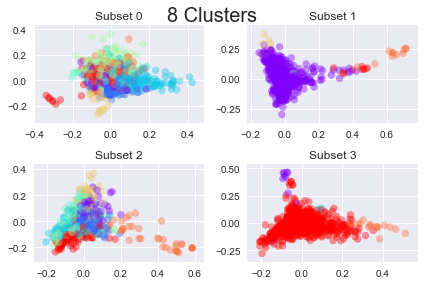

Silhouette Scores: [0.0035870772230050456, 0.03372196137304373, 0.0050726420483428415, 0.018132627643981727]
   n_clust  sil_score_mean  sil_score_error
0      2.0        0.034853         0.042632
1      3.0        0.021091         0.506247
4      6.0        0.016867         0.638408
6      8.0        0.015129         0.802147
3      5.0        0.013446         0.295516
2      4.0        0.013105         0.674305
5      7.0        0.003081         4.855986


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:39: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


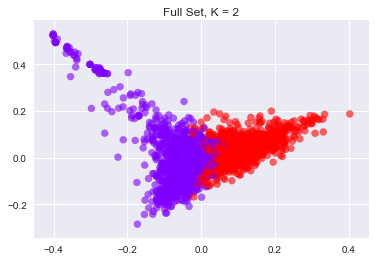

Silhouette Score: 0.0321917642159


In [34]:
def iterate_kmeans(full_set, subsets, clust_range):
    
    cluster_scores = pd.DataFrame(columns=['n_clust','sil_score_mean','sil_score_error'])
    
    for nclust in range(2, clust_range):
        
        f, plotgrid = plt.subplots(2,2)
        sil_scores = []   
        
        for i in range(4):
            model = KMeans(n_clusters=nclust, random_state=1)
            model.fit(subsets[i])
            labels = model.labels_
            cluster_pred = model.predict(subsets[i])
        
            coordinates = pca_2_component(subsets[i])
            xs = coordinates[:,0]
            ys = coordinates[:,1]

            rows = int(np.floor(i / 2))
            cols = i % 2
            colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

            plotgrid[rows, cols].scatter(xs, ys, color = colors[labels], alpha = 0.4)
            plotgrid[rows, cols].set_title(f'Subset {i}')
            
            sil_scores.append(metrics.silhouette_score(subsets[i], labels, metric='euclidean'))
        
        plt.suptitle(f'{nclust} Clusters', fontsize=20)
        plt.tight_layout()
        plt.show()
        
        print('Silhouette Scores:', sil_scores)

        cluster_scores = cluster_scores.append({'n_clust': int(nclust),
                                                'sil_score_mean': np.mean(sil_scores),
                                                'sil_score_error': (np.std(sil_scores)/np.mean(sil_scores))
                                                }, ignore_index = True)
    sorted = cluster_scores.sort(columns='sil_score_mean', ascending = False)
    print(sorted)
    best_clust_num = int(sorted['n_clust'].iloc[0])

    model = KMeans(n_clusters=best_clust_num, random_state=1)
    model.fit(full_set)
    labels = model.labels_
    cluster_pred = model.predict(full_set)

    coordinates = pca_2_component(full_set)
    xs = coordinates[:,0]
    ys = coordinates[:,1]

    colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
    plt.scatter(xs, ys, c=colors[labels], alpha=0.6)
    plt.title(f'Full Set, K = {best_clust_num}')
    plt.show()
    
    print('Silhouette Score:', metrics.silhouette_score(full_set, labels, metric='euclidean'))
    return labels
        
iter_km_tfidf_labels = iterate_kmeans(tX_train, tfidf_subsets, 9)

If we judge by the mean silhouette score for all 4 subsets, we get 2 clusters as the best-performing value. The resultant silhouette score is **0.032**, not very high. <br>

Let's see what the value is for the bag-of-words dataset.

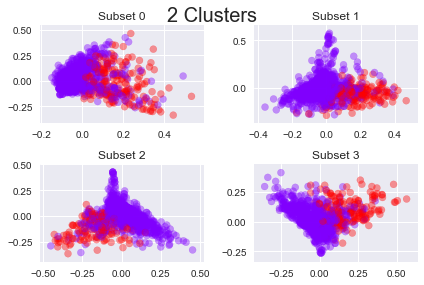

Silhouette Scores: [0.26114352679381081, 0.2783216864573862, 0.26022168830987924, 0.25596897802926377]


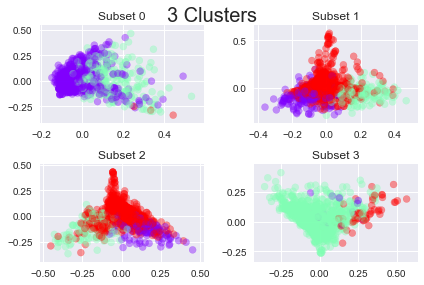

Silhouette Scores: [0.23840082474104352, 0.16492174134865903, 0.19765498077840712, 0.25864118190521967]


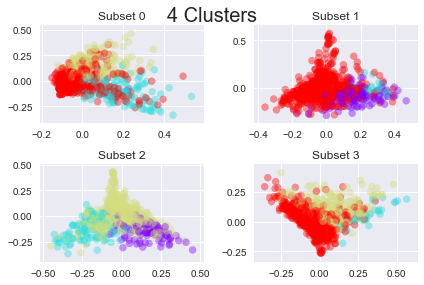

Silhouette Scores: [0.19192291917965074, 0.26469257075283731, 0.19753856738746423, 0.15944724951169104]


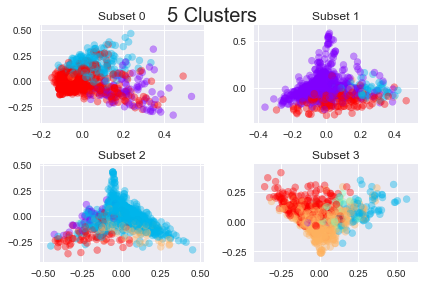

Silhouette Scores: [0.19237541200749222, 0.24219781800761428, 0.22627663161476855, 0.13734579201186706]


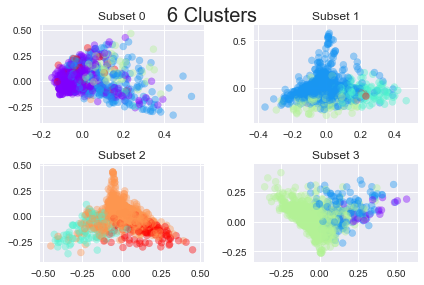

Silhouette Scores: [0.1797668833732694, 0.24164966427568874, 0.047585944257862021, 0.1640467976278632]


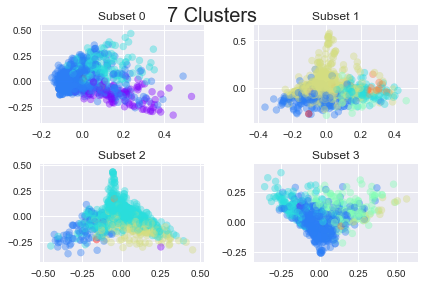

Silhouette Scores: [0.1190848095769324, 0.18523216628099179, 0.14520515999002376, 0.16010146288784541]


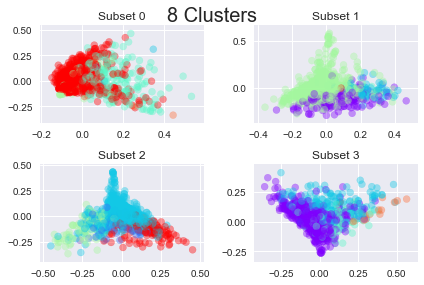

Silhouette Scores: [0.02115733885984368, 0.25206812706845327, 0.15919811248687474, 0.18417008671951049]
   n_clust  sil_score_mean  sil_score_error
0      2.0        0.263914         0.032375
1      3.0        0.214905         0.168752
2      4.0        0.203400         0.188092
3      5.0        0.199549         0.201296
4      6.0        0.158262         0.443415
6      8.0        0.154148         0.544714
5      7.0        0.152406         0.157301


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:39: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


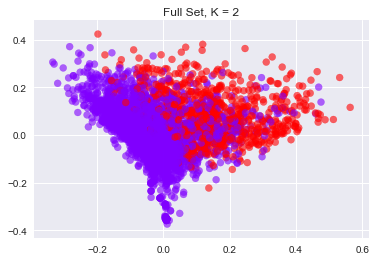

Silhouette Score: 0.246217451312


In [35]:
iter_km_bow_labels = iterate_kmeans(cX_train, bow_subsets, 9)

Again, k = 2 gives the higher silhouette score, this time at **0.246** (our highest silhouette score yet). Visually, none of these cluster assignments appear to cluster the training dataset consistently in this 2-component feature space. The shapes of the subsets are very different from each other, and the colored clusters never appear in the same general area. This holds true no matter what number of clusters we assign to the KMeans object. This is why it is helpful to also look at the mean silhouette score, which considers all dimensions. Designating 2 clusters gave us the highest mean silhouette score. It also gave the lowest standard deviation between subsets which typically indicates that the clustering is stable, however in this case it may be because it has fewer terms contributing to its variance. <br>

Let's look deeper into these clusters using the same analytical tools as before.

In [42]:
tfidf_cluster_pred['k_means_2_pred'] = iter_km_tfidf_labels

for group, rows in tfidf_cluster_pred.groupby('president'):
    value_counts = rows['k_means_2_pred'].value_counts()
    print(group, '0 =', value_counts[0], '; 1 =', value_counts[1])

Clinton 0 = 285 ; 1 = 328
Eisenhower 0 = 604 ; 1 = 165
GWBush 0 = 370 ; 1 = 115
Johnson 0 = 757 ; 1 = 156
Kennedy 0 = 239 ; 1 = 67
Nixon 0 = 299 ; 1 = 97
Reagan 0 = 269 ; 1 = 168
Truman 0 = 664 ; 1 = 259


All presidents are dominant for Cluster 0, which does not tell us much. Additionally, there is not a single president does not appear in both clusters.

In [120]:
bow_cluster_pred['k_means_2_pred'] = iter_km_bow_labels

for group, rows in bow_cluster_pred.groupby('president'):
    value_counts = rows['k_means_2_pred'].value_counts()
    print(group, '0 =', value_counts[0], '; 1 =', value_counts[1])

Clinton 0 = 337 ; 1 = 276
Eisenhower 0 = 671 ; 1 = 98
GWBush 0 = 396 ; 1 = 89
Johnson 0 = 864 ; 1 = 49
Kennedy 0 = 267 ; 1 = 39
Nixon 0 = 355 ; 1 = 41
Reagan 0 = 311 ; 1 = 126
Truman 0 = 792 ; 1 = 131


Again, all presidents are dominant for Cluster 0. Across the board, there seems to be weaker representation in Cluster 1.

In [72]:
t_train_pred['cluster_pred_2'] = iter_km_tfidf_labels
k_means_tfidf_words_2 = get_common_words(iter_km_tfidf_labels, t_train_pred, 'cluster_pred_2')
for key, value in k_means_tfidf_words_2.items():
    print(key, value, '\n')

0 [[('the', 709), ('world', 648), ('nation', 615), ('people', 568), ('america', 503), ('have', 492), (' ', 448), ('congress', 424), ('great', 392), ('peace', 379), ('and', 341), ('new', 339), ('freedom', 339), ('year', 318), ('in', 306), ('country', 304), ('but', 293), ('war', 289), ('government', 286), ('american', 278)]] 

1 [[('year', 905), ('program', 478), ('have', 427), ('work', 412), ('government', 397), ('new', 372), ('the', 363), ('people', 347), ('million', 318), ('federal', 316), ('child', 313), ('tax', 298), ('increase', 294), ('need', 293), ('budget', 271), ('billion', 269), ('dollar', 268), ('and', 264), ('help', 264), ('congress', 257)]] 



In [73]:
c_train_pred['cluster_pred_2'] = iter_km_bow_labels
k_means_bow_words_2 = get_common_words(iter_km_bow_labels, c_train_pred, 'cluster_pred_2')
for key, value in k_means_bow_words_2.items():
    print(key, value, '\n')

0 [[('the', 772), ('nation', 617), ('world', 595), ('people', 556), ('have', 528), (' ', 516), ('congress', 459), ('america', 454), ('great', 396), ('government', 390), ('new', 388), ('and', 377), ('peace', 354), ('year', 332), ('  ', 320), ('freedom', 318), ('in', 315), ('but', 314), ('program', 305), ('work', 296)]] 

1 [[('year', 891), ('have', 391), ('people', 359), ('work', 347), ('new', 323), ('program', 319), ('the', 300), ('government', 293), ('million', 275), ('child', 248), ('help', 245), ('dollar', 245), ('america', 240), ('billion', 238), ('federal', 236), ('and', 228), ('tax', 223), ('congress', 222), ('need', 211), ('increase', 210)]] 



When reducing down to 2 clusters, we see some overlap in the clusters (such as with the words 'program' and 'congress') but the first cluster seems to be more generic American buzzwords while the second cluster seems to be more specific about directives for improvement. Although this clustering makes sense, it is far too broad to capture such a large and diverse dataset. This algorithm is dramatically underfitting the data. <br>

Across all the k-means models, we see the best performance with k=2 on the bag-of-words dataset. This model gave a silhouette score of 0.246 on the training dataset, which was the highest. Every president except Clinton had more datapoints in Cluster 0, which corresponded to generic American buzzwords such as "nation" and "peace". Fewer datapoints fell in Cluster 1, which had slightly more specific words about current American issues. <br>

Let's try a clustering method that determines its own number of clusters: mean-shift.

# Mean-Shift Clustering

In mean-shift cluster, the bandwidth and the quantile are inextricably linked -- together, they determine how smooth the probability surface is, and how much noise it is susceptible to. The estimate_bandwidth function automatically derives a bandwidth based on an inspection of the distances among points in the data. The bandwidth is influenced by the quantile, which can be set by the user. We will iterate through several quantile values to find the best results for mean-shift clustering.

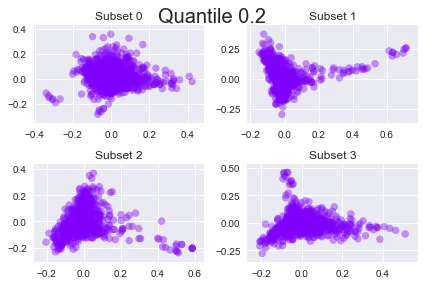

Cluster Estimates: [1, 1, 1, 1]
Silhouette Scores: [0, 0, 0, 0]
Silhouette Scores Mean: 0.0
Silhouette Standard Deviation: 0.0


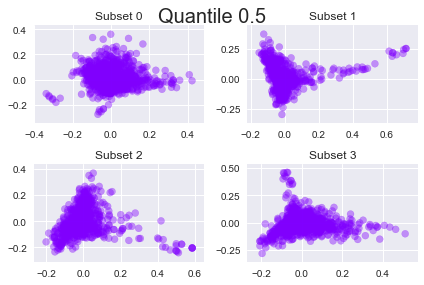

Cluster Estimates: [1, 1, 1, 1]
Silhouette Scores: [0, 0, 0, 0]
Silhouette Scores Mean: 0.0
Silhouette Standard Deviation: 0.0


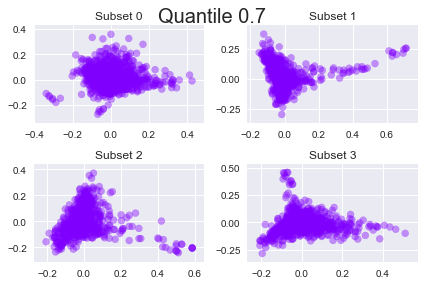

Cluster Estimates: [1, 1, 1, 1]
Silhouette Scores: [0, 0, 0, 0]
Silhouette Scores Mean: 0.0
Silhouette Standard Deviation: 0.0
   cluster_estimate_mean  quantile  sil_scores_mean  sil_scores_std
0                    1.0       0.2              0.0             0.0
1                    1.0       0.5              0.0             0.0
2                    1.0       0.7              0.0             0.0
sorted quantile scores:    cluster_estimate_mean  quantile  sil_scores_mean  sil_scores_std
0                    1.0       0.2              0.0             0.0
1                    1.0       0.5              0.0             0.0
2                    1.0       0.7              0.0             0.0
best cluster num: 1
best quantile: 0.2


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:61: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


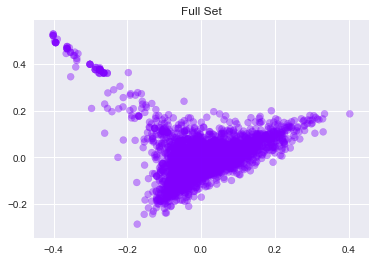

In [76]:
def mean_shift(full_set, subsets):

    quantiles = [0.2, 0.5, 0.7]
    quantile_scores_list = []
    
    # Set up a 4-quadrant plotgrid for every quantile value
    for q in quantiles:
        f, plotgrid = plt.subplots(2, 2)
        cluster_estimates = []
        sil_scores = []

        # Iterate through every subset; fit model and create subplot
        for i in range(4):
            bandwidth = estimate_bandwidth(subsets[i], quantile=q, random_state = 1)
            ms = MeanShift(bandwidth=bandwidth)
            ms.fit_predict(subsets[i])
            
            labels=ms.labels_
            n_clusters_ = len(np.unique(labels))
            cluster_estimates.append(n_clusters_)
            
            coordinates = pca_2_component(subsets[i])
            xs = coordinates[:,0]
            ys = coordinates[:,1]
            
            if n_clusters_ == 1:
                sil_score = 0
            else:
                sil_score = metrics.silhouette_score(subsets[i], labels, metric='euclidean')
            sil_scores.append(sil_score)

            # Set the number of colors to the number of clusters to plot
            num_colors = n_clusters_
            colors = cm.rainbow(np.linspace(0, 1, num_colors))

            rows = int(np.floor(i / 2))
            cols = i % 2

            plotgrid[rows, cols].scatter(xs, ys, color = colors[labels], alpha = 0.4)
            plotgrid[rows, cols].set_title(f'Subset {i}')

        quantile_scores_list.append(
            {
                'quantile': q,
                'cluster_estimate_mean': np.mean(cluster_estimates),
                'sil_scores_mean': np.mean(sil_scores),
                'sil_scores_std': np.std(sil_scores)
            })

        plt.suptitle(f'Quantile {q}', fontsize=20)
        plt.tight_layout()
        plt.show()
        
        print('Cluster Estimates:', cluster_estimates)
        print('Silhouette Scores:', sil_scores)
        print('Silhouette Scores Mean:', np.mean(sil_scores))
        print('Silhouette Standard Deviation:', np.std(sil_scores))

    quantile_scores_df = pd.DataFrame(quantile_scores_list)
    print(quantile_scores_df.head())
    sorted_scores = quantile_scores_df.sort(columns = 'sil_scores_mean', ascending = False)
    print('sorted quantile scores:', sorted_scores)

    best_cluster_num = int(sorted_scores['cluster_estimate_mean'].iloc[0])
    print('best cluster num:', best_cluster_num)
    
    best_quantile = sorted_scores['quantile'].iloc[0]
    print('best quantile:', best_quantile)

    # Fit the full dataset with best quantile value
    bandwidth = estimate_bandwidth(full_set, quantile=best_quantile, random_state = 1)
    ms = MeanShift(bandwidth=bandwidth)
    ms.fit_predict(full_set)

    labels=ms.labels_
    n_clusters_ = len(np.unique(labels))
    cluster_estimates.append(n_clusters_)

    coordinates = pca_2_component(full_set)
    xs = coordinates[:,0]
    ys = coordinates[:,1]
    
    num_colors = n_clusters_
    colors = cm.rainbow(np.linspace(0, 1, num_colors))
    
    plt.scatter(xs, ys, color = colors[labels], alpha = 0.4)
    plt.title(f'Full Set')
    plt.show()
    
    if n_clusters_ > 1:
        print('Silhouette Score:',
            metrics.silhouette_score(full_set, labels, metric='euclidean'))
    
    return labels
    
ms_tfidf_labels = mean_shift(tX_train, tfidf_subsets)

For all 3 tested quantile values, mean-shift gave us only 1 cluster for the tf-idf dataset. It is interesting to see the algorithm underfitting the data so dramatically. Let's try with bag-of-words.

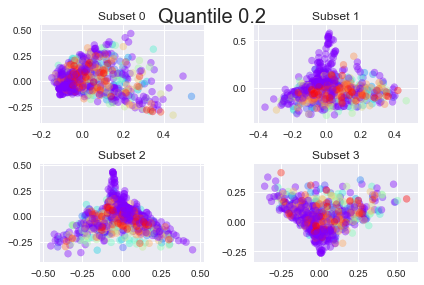

Cluster Estimates: [459, 441, 420, 425]
Silhouette Scores: [0.15581749107046866, 0.15708720222909497, 0.15265261619650247, 0.14948399343314825]
Silhouette Scores Mean: 0.153760325732
Silhouette Standard Deviation: 0.00295017265605


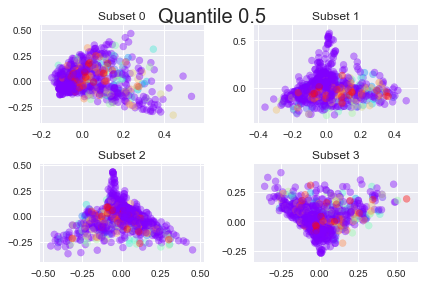

Cluster Estimates: [225, 214, 228, 209]
Silhouette Scores: [0.22475373478693561, 0.21438387818092092, 0.20504088501813045, 0.20837822646139836]
Silhouette Scores Mean: 0.213139181112
Silhouette Standard Deviation: 0.00749493523438


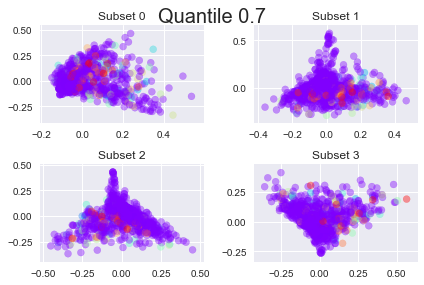

Cluster Estimates: [133, 104, 105, 104]
Silhouette Scores: [0.27214260860509271, 0.26877975981814245, 0.25925061607807176, 0.26081007894977715]
Silhouette Scores Mean: 0.265245765863
Silhouette Standard Deviation: 0.00537756200383
   cluster_estimate_mean  quantile  sil_scores_mean  sil_scores_std
0                 436.25       0.2         0.153760        0.002950
1                 219.00       0.5         0.213139        0.007495
2                 111.50       0.7         0.265246        0.005378
sorted quantile scores:    cluster_estimate_mean  quantile  sil_scores_mean  sil_scores_std
2                 111.50       0.7         0.265246        0.005378
1                 219.00       0.5         0.213139        0.007495
0                 436.25       0.2         0.153760        0.002950
best cluster num: 111
best quantile: 0.7


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:61: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


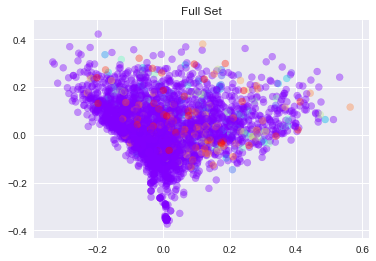

Silhouette Score: 0.254669191057


In [77]:
ms_bow_labels = mean_shift(cX_train, bow_subsets)

This is a dramatic difference between the tf-idf vs. bag-of-words comparison. The same algorithm, with the same hyper-parameters, estimated 1 cluster for tf-idf and over **300 clusters** for bag-of-words! Bag-of-words identifies key words, while tf-idf quantifies them. Most literature shows that tf-idf performs better than bag-of-words since it is closely based on it but packs more information into each feature, but in some cases it can over-complicate the model, missing the mark on true similarity.

Source: https://stats.stackexchange.com/questions/153069/bag-of-words-for-text-classification-why-not-just-use-word-frequencies-instead

It is possible that with 1 cluster, tf-idf is severely underfitting the data because there is simply not enough data in each class to provide the vectorizer enough information to work with. Natural language processing works best on corpuses with extensive amounts of data, and especially when breaking our data down into 8 classes (as opposed to a simpler task of 2 or 3) we need large amounts of data to train our models.

The silhouette score is on par with the silhouette scores from other algorithms, so at first glance I wouldn't say that these 282 clusters are any more defined than the 8 clusters above. It would likely be too much to look at each cluster's breakdown, so let's look at each president's breakdown for bag-of-words (tf-idf only has 1 cluster).

(array([ 4490.,    39.,    39.,    38.,    39.,    39.,    40.,    39.,
           40.,    39.]),
 array([   0. ,   38.7,   77.4,  116.1,  154.8,  193.5,  232.2,  270.9,
         309.6,  348.3,  387. ]),
 <a list of 10 Patch objects>)

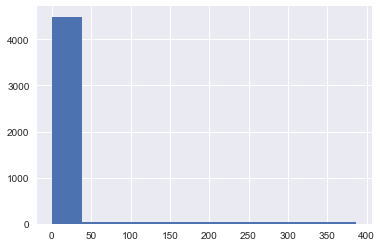

In [78]:
bow_cluster_pred['ms_pred'] = ms_bow_labels
plt.hist(bow_cluster_pred['ms_pred'])

All presidents have the majority of their datapoints in the first cluster, with a maximum of 1 datapoint per any other cluster. What sort of words are in this first cluster?

In [121]:
c_train_pred['ms_pred'] = ms_bow_labels
ms_bow_words = get_common_words(ms_bow_labels, c_train_pred, 'ms_pred')
for key, value in ms_bow_words.items():
    print(key, value, '\n')

0 [[('year', 919), ('the', 864), ('people', 730), ('have', 689), ('nation', 630), ('world', 622), ('congress', 567), ('america', 553), ('government', 534), ('new', 526), ('work', 496), ('and', 473), ('program', 467), ('great', 435), ('need', 398), ('american', 388), ('in', 377), ('help', 370), ('but', 368), ('peace', 365)]] 

1 [[('small', 5), ('new', 5), ('business', 4), ('propose', 4), ('credit', 3), ('create', 2), ('job', 2), ('firm', 2), ('percent', 2), ('and', 2), ('because', 1), ('high', 1), ('percentage', 1), ('nation', 1), ('10', 1), ('15', 1), ('year', 1), ('plan', 1), ('include', 1), ('bold', 1)]] 

2 [[('weapon', 4), ('saddam', 3), ('hussein', 3), ('year', 2), ('possible', 2), ('people', 2), ('terrorist', 2), ('go', 1), ('elaborate', 1), ('length', 1), ('spend', 1), ('enormous', 1), ('sum', 1), ('take', 1), ('great', 1), ('risk', 1), ('build', 1), ('mass', 1), ('destruction', 1), ('the', 1)]] 

3 [[('communist', 2), ('tactic', 2), ('shift', 2), ('reliance', 2), ('violence', 

These clusters seem much more meaningful and specific than any of the preceding clusters. The largest cluster includes generic words about American government, while each cluster after that has a clear theme such as financing college, stimulating economy, the environment, etc. These topics are much more easy to discern than the preceding clusters. However, there are 388 clusters, the majority of which have only one observation, which is an indicator of overfitting.

# Supervised Learning

The results from clustering do not classify the data by president, as evidenced by their poor silhouette scores (for k=8) and extreme cluster estimates (1 cluster for tf-idf and 282 for bag-of-words). Since the president of the speech is our desired outcome, let's try using supervised methods. We will start by using random forest with grid search to find the best parameters.

In [45]:
rf_params = [{'max_depth': [50, 100], 'max_features': [50, 100],
              'min_samples_split': [10, 50, 100], 'n_estimators': [10],
              'random_state': [1]
             }]                    

grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=3)
grid.fit(tX_train, tY_train)
print(f'best params:\n {grid.best_params_}')

trfc = RandomForestClassifier(**grid.best_params_)
trfc.fit(tX_train, tY_train)
trfc_test_pred = trfc.predict(tX_test)
print(f'Testing Accuracy: {accuracy_score(tY_test, trfc_test_pred)}')
print(f'Cross Val Score: {cross_val_score(trfc, tX_train, tY_train, cv=3).mean()}')
print(pd.crosstab(tY_test, trfc_test_pred))

best params:
 {'max_depth': 100, 'max_features': 50, 'min_samples_split': 50, 'n_estimators': 10, 'random_state': 1}
Testing Accuracy: 0.4349442379182156
Cross Val Score: 0.42026955480614653
col_0       Clinton  Eisenhower  GWBush  Johnson  Kennedy  Nixon  Reagan  \
president                                                                  
Clinton         140          10       6       36        0      2      16   
Eisenhower        4          94       3       78        0      5       5   
GWBush           23           7      59       43        0      1       1   
Johnson          18          23       1      204        1      1      10   
Kennedy           4          19       0       39        1      1       2   
Nixon            13          15       3       60        0     14       7   
Reagan           32          31       8       32        1      1      30   
Truman            4          45       2       73        1      1       5   

col_0       Truman  
president           
Clinto

As I increase the range of the hyperparameters, the performance increases. However, after about 100 features per hyperparameter, the grid search becomes too expensive to run. I imagine the accuracy score would increase (up to a certain point) but for now my classifier maxes out at **0.435**, which is not very accurate. The cross-validation score is 0.420, which shows that the model is not overfitting strongly. These scores could potentially benefit from iterating through more hyperparameters for the vectorizer that generates the features. <br>

By looking at the confusion matrix of president classifications, we can see that Reagan is misclassifying often, (often mistaken for Clinton and Johnson), and Johnson and Truman do not perform very well either. Clinton and GWBush are the easiest for the models to identify.

In [46]:
grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=3)
grid.fit(cX_train, cY_train)
print(f'best params:\n {grid.best_params_}')

crfc = RandomForestClassifier(**grid.best_params_)
crfc.fit(cX_train, cY_train)
crfc_test_pred = crfc.predict(cX_test)
print(f'Testing Accuracy: {accuracy_score(cY_test, crfc_test_pred)}')
print(f'Cross Val Score: {cross_val_score(crfc, cX_train, cY_train, cv=3).mean()}')
print(pd.crosstab(cY_test, crfc_test_pred))

best params:
 {'max_depth': 100, 'max_features': 100, 'min_samples_split': 10, 'n_estimators': 10, 'random_state': 1}
Testing Accuracy: 0.4448574969021066
Cross Val Score: 0.42773331637529677
col_0       Clinton  Eisenhower  GWBush  Johnson  Kennedy  Nixon  Reagan  \
president                                                                  
Clinton         138           3       9       45        0      3       9   
Eisenhower       10          83       0       85        2      7       2   
GWBush           16           4      69       44        0      2       4   
Johnson          15          28       2      204        1      9       4   
Kennedy           3          20       0       51        2      4       3   
Nixon            17          12       1       46        0     31       7   
Reagan           27          23       4       46        0     11      29   
Truman            2          46       0       77        0      3       1   

col_0       Truman  
president           
Clint

KeyError: 'president'

In [68]:
cm = pd.crosstab(cY_test, crfc_test_pred)
print(cm.reset_index())
print(cm.reset_index().sum(axis=1))
print(cY_test.value_counts())

col_0   president  Clinton  Eisenhower  GWBush  Johnson  Kennedy  Nixon  \
0         Clinton      138           3       9       45        0      3   
1      Eisenhower       10          83       0       85        2      7   
2          GWBush       16           4      69       44        0      2   
3         Johnson       15          28       2      204        1      9   
4         Kennedy        3          20       0       51        2      4   
5           Nixon       17          12       1       46        0     31   
6          Reagan       27          23       4       46        0     11   
7          Truman        2          46       0       77        0      3   

col_0  Reagan  Truman  
0           9      13  
1           2      74  
2           4       5  
3           4      41  
4           3      16  
5           7      27  
6          29      12  
7           1     162  
0    220
1    263
2    144
3    304
4     99
5    141
6    152
7    291
dtype: int64
Johnson       304
Truma

The random forest using the bag-of-words dataset performed on-par with the tf-idf dataset (0.435 vs. **0.445**). Again, not impressive. This model is hardly overfitting at all, with a cross-validation score of 0.428. This means that the model generalizes well to unseen data, but because the model is not showing good accuracy to begin with, it is not capturing the variance of the underlying data and is therefore underfitting.<br>

Let's try logistic regression, a robust classifier that is inexpensive to run.

In [69]:
logistic_params = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 50, 100, 1000, 10000],
                   'penalty': ['l1','l2']}

grid = GridSearchCV(LogisticRegression(), logistic_params, cv=3)
grid.fit(tX_train, tY_train)
print(f'best params:\n {grid.best_params_}')

tlr = LogisticRegression(**grid.best_params_)
tlr.fit(tX_train, tY_train)
tlr_test_pred = tlr.predict(tX_test)
print(f'Testing Accuracy: {accuracy_score(tY_test, tlr_test_pred)}')
print(f'Cross Val Score: {cross_val_score(tlr, tX_train, tY_train, cv=3).mean()}')
print(pd.crosstab(cY_test, tlr_test_pred))

best params:
 {'C': 10, 'penalty': 'l2'}
Testing Accuracy: 0.5700123915737298
Cross Val Score: 0.5338830523072358
col_0       Clinton  Eisenhower  GWBush  Johnson  Kennedy  Nixon  Reagan  \
president                                                                  
Clinton         169           3       5       30        2      0       5   
Eisenhower        1         137       3       50        8      6       5   
GWBush           13           3      82       35        2      2       4   
Johnson          11          24       2      204        5     12      10   
Kennedy           1          18       0       45       23      1       2   
Nixon             6          16       2       26        4     64       7   
Reagan           16          16       4       19        3     11      72   
Truman            3          40       1       67        2      6       3   

col_0       Truman  
president           
Clinton          6  
Eisenhower      53  
GWBush           3  
Johnson         36  

In [70]:
cm = pd.crosstab(tY_test, tlr_test_pred)
print(cm.reset_index())
print(cm.reset_index().sum(axis=1))
print(cY_test.value_counts())

col_0   president  Clinton  Eisenhower  GWBush  Johnson  Kennedy  Nixon  \
0         Clinton      169           3       5       30        2      0   
1      Eisenhower        1         137       3       50        8      6   
2          GWBush       13           3      82       35        2      2   
3         Johnson       11          24       2      204        5     12   
4         Kennedy        1          18       0       45       23      1   
5           Nixon        6          16       2       26        4     64   
6          Reagan       16          16       4       19        3     11   
7          Truman        3          40       1       67        2      6   

col_0  Reagan  Truman  
0           5       6  
1           5      53  
2           4       3  
3          10      36  
4           2       9  
5           7      16  
6          72      11  
7           3     169  
0    220
1    263
2    144
3    304
4     99
5    141
6    152
7    291
dtype: int64
Johnson       304
Truma

Ridge regression outperforms lasso regression with an accuracy of **0.57**. While this is not very high, it is currently our highest score. This corresponds to a cross-validation score of 0.534, which is overfitting slightly but not concerning. <br>

Also, Truman and Johnson appear to be misclassified more often than other presidents. Truman is most often mistaken for Eisenhower, which is likely due to Truman preceding Eisenhower chronologically.

In [114]:
grid = GridSearchCV(LogisticRegression(), logistic_params, cv=3)
grid.fit(cX_train, cY_train)
print(f'best params:\n {grid.best_params_}')

clr = LogisticRegression(**grid.best_params_)
clr.fit(cX_train, cY_train)
clr_test_pred = lr.predict(cX_test)
print(f'Testing Accuracy: {accuracy_score(cY_test, clr_test_pred)}')
print(f'Cross Val Score: {cross_val_score(clr, cX_train, cY_train, cv=3).mean()}')
print(pd.crosstab(cY_test, clr_test_pred))

best params:
 {'C': 1, 'penalty': 'l2'}
Testing Accuracy: 0.5613382899628253
Cross Val Score: 0.5245920427521759
col_0       Clinton  Eisenhower  GWBush  Johnson  Kennedy  Nixon  Reagan  \
president                                                                  
Clinton         163           2       4       28        3      4      11   
Eisenhower        2         131       1       56       11      8       5   
GWBush           13           3      81       37        3      2       3   
Johnson          11          18       4      210        9     14       6   
Kennedy           4          14       0       51       22      2       2   
Nixon             5          15       2       34        5     59       9   
Reagan           19          10       5       23        3     10      70   
Truman            5          39       0       66        4      4       3   

col_0       Truman  
president           
Clinton          5  
Eisenhower      49  
GWBush           2  
Johnson         32  


Similar to the tf-idf score of 0.57 above, using ridge regression on the bag-of-words dataset gives an accuracy score of **0.561**. This is currently our highest score. It is also overfitting very slightly, but again not enough that I would consider it a problem. President predictions are similar to the tf-idf dataset. <br>

Now, let's try a classifier that is commonly used for language processing: Naive Bayes.

In [117]:
gnb = GaussianNB()
gnb.fit(tX_train, tY_train)
test_pred = gnb.predict(tX_test)
print(f'Testing Accuracy: {accuracy_score(tY_test, test_pred)}')
print(f'Cross Val Score: {cross_val_score(gnb, tX_train, tY_train, cv=3).mean()}')
print(pd.crosstab(tY_test, test_pred))

Testing Accuracy: 0.40582403965303593
Cross Val Score: 0.38146557090682265
col_0       Clinton  Eisenhower  GWBush  Johnson  Kennedy  Nixon  Reagan  \
president                                                                  
Clinton         130          12      36        9        3     11      12   
Eisenhower        7         110       6       14       15     48      16   
GWBush           21           2      73        5        0     35       6   
Johnson          18          24      16       94       34     88      17   
Kennedy           5          19       0       14       19     30       3   
Nixon            14           9       6       15        5     60      19   
Reagan           25          12      10       13        8     19      52   
Truman            8          36       9       26       22     56      17   

col_0       Truman  
president           
Clinton          7  
Eisenhower      47  
GWBush           2  
Johnson         13  
Kennedy          9  
Nixon           1

In [118]:
gnb = GaussianNB()
gnb.fit(cX_train, cY_train)
test_pred = gnb.predict(cX_test)
print(f'Testing Accuracy: {accuracy_score(cY_test, test_pred)}')
print(f'Cross Val Score: {cross_val_score(gnb, cX_train, cY_train, cv=3).mean()}')
print(pd.crosstab(cY_test, test_pred))

Testing Accuracy: 0.4045848822800496
Cross Val Score: 0.3907515893203774
col_0       Clinton  Eisenhower  GWBush  Johnson  Kennedy  Nixon  Reagan  \
president                                                                  
Clinton         129           9      37       10        4     13      14   
Eisenhower        5          95       5       20       23     48      14   
GWBush           21           2      77        4        0     35       5   
Johnson          20          13      15       92       37     93      18   
Kennedy           3          14       1       18       22     31       1   
Nixon            10           7      10       16        7     64      18   
Reagan           20           6      13       17        9     21      57   
Truman            8          27      14       27       22     58      18   

col_0       Truman  
president           
Clinton          4  
Eisenhower      53  
GWBush           0  
Johnson         16  
Kennedy          9  
Nixon            9 

With a Gaussian Naive Bayes model, we get very similar accuracies of **0.406** and **0.405**, neither of which are overfitting significantly. In these models, Nixon performs more poorly than in previous models, and has more datapoints represented in the outcome. Johnson performs better than in previous models, where he was one of the most misclassified presidents.

In [119]:
bnb = BernoulliNB()
bnb.fit(tX_train, tY_train)
test_pred = bnb.predict(tX_test)
print(f'Testing Accuracy: {accuracy_score(tY_test, test_pred)}')
print(f'Cross Val Score: {cross_val_score(bnb, tX_train, tY_train, cv=3).mean()}')

Testing Accuracy: 0.5247831474597274
Cross Val Score: 0.4725330904226462


In [120]:
bnb = BernoulliNB()
bnb.fit(cX_train, cY_train)
test_pred = bnb.predict(cX_test)
print(f'Testing Accuracy: {accuracy_score(cY_test, test_pred)}')
print(f'Cross Val Score: {cross_val_score(bnb, cX_train, cY_train, cv=3).mean()}')

Testing Accuracy: 0.5247831474597274
Cross Val Score: 0.4725330904226462


With a Bernoulli Naive Bayes model, we get better accuracies at **0.525** for both datasets. This is higher than the Gaussian scores, but is also overfitting a little bit more than the Gaussian models (5% compared to 2%). Bernoulli works well on binary data, data in which features are either 0 or 1. Our vectorizers were not configured for binary output, so future considerations could include trying binarized data for this model. This would involve including a 0/1 for whether or not the word is present in the document as opposed to how many times the word is present. Much of our data in bag-of-words is likely binary to begin with, but we could make it completely binary and re-try this Bernoulli model.

In [121]:
mnb = MultinomialNB()
mnb.fit(tX_train, tY_train)
test_pred = mnb.predict(tX_test)
print(f'Testing Accuracy: {accuracy_score(tY_test, test_pred)}')
print(f'Cross Val Score: {cross_val_score(mnb, tX_train, tY_train, cv=3).mean()}')

Testing Accuracy: 0.46902106567534074
Cross Val Score: 0.4417648457736633


In [122]:
mnb = MultinomialNB()
mnb.fit(cX_train, cY_train)
test_pred = mnb.predict(cX_test)
print(f'Testing Accuracy: {accuracy_score(cY_test, test_pred)}')
print(f'Cross Val Score: {cross_val_score(mnb, cX_train, cY_train, cv=3).mean()}')

Testing Accuracy: 0.5526641883519207
Cross Val Score: 0.5095067481681615


A Multinomial Naive Bayes model gave us scores of **0.469** and **0.552**. Of the Naive Bayes classifiers, Multinomial with bag-of-words gave us the best score, with a small 3-4% overfitting. This model assumes a multinomial distribution, which works well for data that can easily be turned into counts, such as the word counts in text we get from bag-of-words.

One classifier we have not tried yet is SVC. Because it is quite computationally expensive we will implement LinearSVC instead of SVC.

In [123]:
svc = LinearSVC()
svc.fit(tX_train, tY_train)
test_pred = svc.predict(tX_test)
print(f'Testing Accuracy: {accuracy_score(tY_test, test_pred)}')
print(f'Cross Val Score: {cross_val_score(svc, tX_train, tY_train, cv=3).mean()}')
print(pd.crosstab(tY_test, test_pred))

Testing Accuracy: 0.5731102850061958
Cross Val Score: 0.5313970614068223
col_0       Clinton  Eisenhower  GWBush  Johnson  Kennedy  Nixon  Reagan  \
president                                                                  
Clinton         170           5       5       28        1      1       5   
Eisenhower        1         133       4       48       12      8       7   
GWBush           12           2      84       35        1      1       5   
Johnson          14          22       4      198        5     15      14   
Kennedy           1          17       0       44       25      1       2   
Nixon             7          16       3       22        5     67       7   
Reagan           18          13       5       16        3     11      79   
Truman            4          39       1       64        3      6       5   

col_0       Truman  
president           
Clinton          5  
Eisenhower      50  
GWBush           4  
Johnson         32  
Kennedy          9  
Nixon           14 

In [124]:
svc = LinearSVC()
svc.fit(cX_train, cY_train)
test_pred = svc.predict(cX_test)
print(f'Testing Accuracy: {accuracy_score(cY_test, test_pred)}')
print(f'Cross Val Score: {cross_val_score(svc, cX_train, cY_train, cv=3).mean()}')
print(pd.crosstab(cY_test, test_pred))

Testing Accuracy: 0.5130111524163569
Cross Val Score: 0.48081030245471273
col_0       Clinton  Eisenhower  GWBush  Johnson  Kennedy  Nixon  Reagan  \
president                                                                  
Clinton         154           4       6       33        3      5       6   
Eisenhower        3         107       5       56       20     16       5   
GWBush           16           2      78       33        1      5       4   
Johnson           7          23       9      187       12     20      14   
Kennedy           3          15       3       45       26      1       3   
Nixon             5          16       4       31        7     59       7   
Reagan           19          15       4       22        8     12      65   
Truman            4          38       3       62        9     14       9   

col_0       Truman  
president           
Clinton          9  
Eisenhower      51  
GWBush           5  
Johnson         32  
Kennedy          3  
Nixon           12

LinearSVC with the tf-idf dataset performed the best out of all the classifiers we have tried so far, with a testing accuracy of **0.573** and slight overfitting (~3%). Support vector machines tend to be effective in high-dimensional space. Although bag-of-words has mostly performed better thus far, tf-idf is theorized to perform better in most cases so it makes sense that the highest performing model would use the tf-idf features. The distribution of president estimates did not appear to be dramatically different than any before it.

# Results

In [132]:
unsupervised_results = pd.DataFrame(columns = ['Technique','Dataset','Hyperparameters','Num Clusters','Silhouette Score'])
unsupervised_results['Technique'] = ['k-means','k-means','mean-shift','mean-shift']
unsupervised_results['Dataset'] = ['tf_idf','bag of words','tf-idf','bag of words']
unsupervised_results['Hyperparameters'] = ['k=2','k=2','quantile=0.2','quantile=0.7']
unsupervised_results['Num Clusters'] = [2,2,1,388]
unsupervised_results['Silhouette Score'] = [0.032,0.246,0,0.255]

unsupervised_results

,Technique,Dataset,Hyperparameters,Num Clusters,Silhouette Score
0,k-means,tf_idf,k=2,2,0.032
1,k-means,bag of words,k=2,2,0.246
2,mean-shift,tf-idf,quantile=0.2,1,0.000
3,mean-shift,bag of words,quantile=0.7,388,0.255


In [133]:
supervised_results = pd.DataFrame(columns = ['Technique','Dataset','Hyperparameters','Cross-Validation Score','Testing Score'])
supervised_results['Technique'] = ['random forest','random forest','logistic regression','logistic regression',
                                  'naive bayes - gaussian','naive bayes - gaussian','naive bayes - bernoulli',
                                  'naive bayes - bernoulli','naive bayes - multinomial','naive bayes - multinomial',
                                  'linear SVC','linear SVC']
supervised_results['Dataset'] = ['tf_idf','bag of words','tf-idf','bag of words','tf_idf','bag of words',
                                'tf_idf','bag of words','tf_idf','bag of words','tf_idf','bag of words',]
supervised_results['Hyperparameters'] = ['max depth = 100, max features = 50, min samples split = 50, n estimators = 10',
                                        'max depth = 100, max features = 100, min samples split = 10, n estimators = 10',
                                        'C = 10, penalty = l2','C = 1, penalty = l2','default','default','default',
                                        'default','default','default','C = 1', 'C = 1']
supervised_results['Cross-Validation Score'] = [0.42,0.428,0.534,0.524,0.381,0.391,0.473,0.473,0.442,0.51,0.531,0.481]
supervised_results['Testing Score'] = [0.435,0.445,0.57,0.561,0.406,0.406,0.525,0.525,0.469,0.553,0.573,0.513]

print('\n\n')
supervised_results

,Technique,Dataset,Hyperparameters,Cross-Validation Score,Testing Score
0,random forest,tf_idf,"max depth = 100, max features = 50, min sample...",0.420,0.435
1,random forest,bag of words,"max depth = 100, max features = 100, min sampl...",0.428,0.445
2,logistic regression,tf-idf,"C = 10, penalty = l2",0.534,0.570
3,logistic regression,bag of words,"C = 1, penalty = l2",0.524,0.561
4,naive bayes - gaussian,tf_idf,default,0.381,0.406
5,naive bayes - gaussian,bag of words,default,0.391,0.406
6,naive bayes - bernoulli,tf_idf,default,0.473,0.525
7,naive bayes - bernoulli,bag of words,default,0.473,0.525
8,naive bayes - multinomial,tf_idf,default,0.442,0.469
9,naive bayes - multinomial,bag of words,default,0.510,0.553


# Conclusion

In this assignment, I wanted to compare supervised and unsupervised learning models on a dataset of natural language including state of the union speeches from various presidents. I used two methods of feature generation, tf-idf and bag-of-words, to convert paragraphs into feature vectors. I chose the president of the speech as the outcome feature to evaluate. <br>

I ran both transformed datasets through 2 clustering algorithms; k-means and mean-shift. Visually, the clusters were not very stable. I broke each dataset into 4 subsets to evaluate the stability of their clustering, and every subset showed different cluster arrangements. Silhouette scores generally ranged from 0 - 0.2, which is another indicator of instability. Any score above 0 indicates that our model is clustering better than random assignment would, but we would like to see scores closer to 1 to feel confident in our models. <br>

The bag-of-words dataset consistently gave better silhouette scores. Both algorithms separated paragraphs by topic (e.g. taxes, jobs), with mean-shift on bag-of-words showing much more distinguishable topics. Although more specific, the extreme number of clusters (with as few as 1 datapoint in some clusters) was indicative that the model was subject to extreme overfitting. The k-means topics were much more broad -- in the interest of time, I only specified a few values for k-means to iterate through, which was likely the reason the topics were so broad with some words overlapping. In the future, iterating through more values of k-means could potentially bring the clusters to a middle ground of specificity that is not underfitting or overfitting as we saw here.

The way the features are constructed has a significant effect on the way the algorithms cluster the data. For example, I lemmatized each word in the paragraph so that conjugations of words would be grouped together instead of treated individually. This avoids creating too many noisy features that are only used a few times, which would complicate the feature space unnecessarily. High dimensional, sparse dataframes can be difficult to work with, so it is better to pack more information into fewer features when possible. For the same reason, stop-words and generic pronouns such as "we" and "our" were excluded from our features. When lemmatizing words, all pronouns are converted to the term "-PRON-". A model might interpret as similarity when there is none, which would lead to underfitting as it would underestimate the complexity of the feature space.

In this report, all pronouns were treated equally, but to successfully cluster by president one could try including only proper name pronouns, such as mentions of Vice Presidents or other world leaders. This would allow the algorithm to cluster by which political figure or countries were relevant at that time, which would correspond to president. For example, the president during WWII (Truman) would likely have more mentions of "Germany" or "Hitler". However, adding in these very specific features could also lead to overfitting.<br>

I also tried several supervised learning techniques to classify paragraphs by president, including random forest, logistic regression (with lasso and ridge), naive bayes, and support vector machines. For these models, neither tf-idf nor bag-of-words consistently performed better, and none of the models performed particularly well. The highest score was an accuracy of 0.573 on the holdout group, achieved using Linear SVC on the tf-idf dataset. These models were tuned with several different hyperparameters (to little avail), so their poor performance may be partially attributed to the fact that the vectorizers were not tuned accordingly. Changing the minimum and maximum number of times a word appears in the corpus can have a dramatic effect on the transformed dataset, and is certainly something to explore in future considerations.

Overall, it is easy to see through this report the difficulties in natural language processing and treating words like numbers. There are many decisions to be made in the process of clustering/predicting language features, each with their own set of pros and cons. In the feature generation phase, we could add sentence summary and paragraph summary features such as number of words per paragraph or number of proper pronouns used. We could also tune the hyperparameters of the various vectorizers and run the resulting feature sets through prediction pipelines. In the clustering phase, we could try higher values for k-means and more data sets, including a dataset with proper pronouns. In the supervised modeling phase, we could use more feature sets, experiment with more hyper-parameters for random forest, and try the computationally expensive SVC model with various hyper-parameters.

Once we have exhausted our options for these term-frequency based models, we can try other more sophisticated methods of feature generation that include context such as word2vec. All in the hopes of improving our accuracy, but keeping in mind that some models are not meant to be tamed. Some data sets simply don't have enough data to train accurate models, and some data sets are too complex to be represented by simple techniques like bag-of-words and tf-idf.